### Image Classification: Natural Images

More information about the dataset: https://www.kaggle.com/datasets/prasunroy/natural-images/data

![dog](natural_images_classification/train/dog/dog_0003.jpg) ![fruit](natural_images_classification/train/fruit/fruit_0067.jpg) ![airplane](natural_images_classification/train/airplane/airplane_0061.jpg) ![person](natural_images_classification/train/person/person_0024.jpg) ![car](natural_images_classification/train/car/car_0026.jpg) ![cat](natural_images_classification/train/cat/cat_0006.jpg) ![flower](natural_images_classification/train/flower/flower_0074.jpg) ![motorbike](natural_images_classification/train/motorbike/motorbike_0067.jpg)

#### Dataset Description

- 6.900 images

- Images are 128x128 in size

- 8 distinct classes

    - airplane 

    - car

    - cat 

    - dog 

    - flower

    - fruit

    - motorbike
    
    - person

### Loading Libraries

In [84]:
# First, we load the necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time

from sklearn.metrics import confusion_matrix

import pathlib
import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim


## Data Exploration

#### Data Structure

```
natural_images_classification/
├── train
│   ├── airplane
│       ├── airplane_0002.jpg
│       ├── airplane_0004.jpg
│       └── ...
│   ├── car
│   └── ...
│
├── validation
│   ├── airplane
│       ├── airplane_0001.jpg
│       ├── airplane_0003.jpg
│       └── ...
│   ├── car
│   └── ...
│
├── test
│   ├── airplane
│       ├── airplane_0000.jpg
│       ├── airplane_0011.jpg
│       └── ...
│   ├── car
│   └── ...
```

In [85]:
# Print the folders inside
print(os.listdir('natural_images_classification'))

['test', 'train', 'validation']


In [86]:
# Print classes
train_folder = 'natural_images_classification/train'
val_folder = 'natural_images_classification/validation'
test_folder = 'natural_images_classification/test'

print("Training image classes: ", os.listdir(train_folder))
print("Validation image classes: ", os.listdir(val_folder))
print("Test image classes: ", os.listdir(test_folder))

Training image classes:  ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Validation image classes:  ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Test image classes:  ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


#### Number of images in each class

Let's see the number of images within each class. This will tell us if the dataset is balanced across the different classes or if some classes have significantly more examples than others.

In [87]:
# Function to count the number of images in each class 
def get_num_images(folder):
    classes = sorted(os.listdir(folder))
    num_images = []
    for c in classes:
        images = os.listdir(f'{folder}/{c}')
        num_images.append(len(images))
    return num_images, classes

train data: 4827 images
validation data: 1032 images
test data: 1041 images


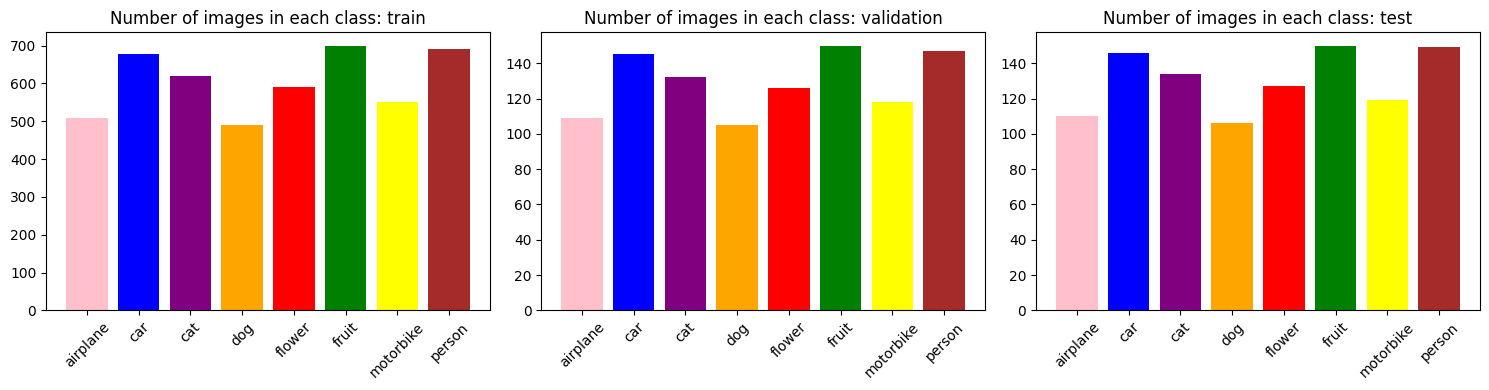

In [88]:
data = ["train", "validation", "test"]
folder = [train_folder, val_folder, test_folder]
color = ['pink', 'blue', 'purple', 'orange', 'red', 'green', 'yellow', 'brown']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
axes = axes.ravel()
for i, ax in enumerate(axes):
    num_images, classes = get_num_images(folder[i])
    print(f"{data[i]} data: {np.array(num_images).sum()} images")
    ax.figure
    ax.bar(classes, num_images, color=color)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(f"Number of images in each class: {data[i]}")
plt.tight_layout()
plt.show()

We have a balanced dataset. There is approximately the same number of each class in each training, validation, and test set.

#### Pillow (PIL) Library (https://python-pillow.org/)

Library for image processing. We will use Pillow to read and display images.

Image size:  (128, 128)


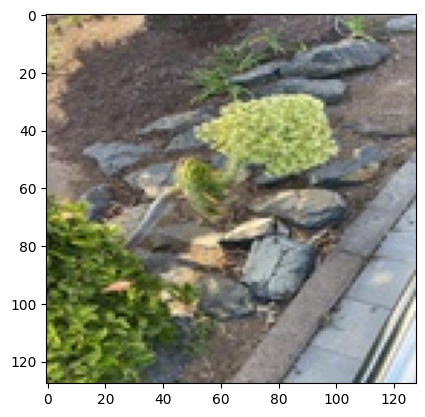

In [89]:
# View an example of one of the images
# Read the image with Pillow (PIL)
image = Image.open(os.path.join(train_folder, 'flower/img_flower.jpg'))
print("Image size: ", image.size)
plt.imshow(image)
plt.show()

In [90]:
# View the pixel values
# It has format (H x W x C) (height, width, channels)
numpy_image = np.asarray(image)
print(numpy_image.shape)
print('valor máximo de los píxeles: ', numpy_image.max())
print('valor mínimo de los píxeles: ', numpy_image.min())

(128, 128, 3)
valor máximo de los píxeles:  255
valor mínimo de los píxeles:  0


In [91]:
# Pixel values in the image
numpy_image

array([[[201, 197, 170],
        [156, 150, 126],
        [163, 150, 133],
        ...,
        [145, 151, 163],
        [151, 156, 178],
        [155, 161, 187]],

       [[199, 191, 168],
        [147, 136, 116],
        [144, 131, 114],
        ...,
        [179, 185, 197],
        [181, 188, 207],
        [185, 191, 213]],

       [[139, 122, 106],
        [131, 114,  98],
        [128, 113,  94],
        ...,
        [163, 171, 182],
        [164, 174, 186],
        [163, 172, 187]],

       ...,

       [[107, 121,  36],
        [133, 149,  61],
        [151, 167,  78],
        ...,
        [238, 246, 249],
        [234, 237, 244],
        [230, 231, 236]],

       [[ 69,  79,  10],
        [ 52,  63,   0],
        [140, 151,  82],
        ...,
        [235, 243, 246],
        [233, 236, 243],
        [220, 223, 230]],

       [[ 85,  93,  33],
        [127, 135,  75],
        [112, 122,  61],
        ...,
        [229, 237, 240],
        [233, 238, 244],
        [213, 216, 225]]

In [92]:
# Total number of pixels = 128 x 128 x 3

print("Número total de píxeles en la imagen :", numpy_image.shape[0] * numpy_image.shape[1] * numpy_image.shape[2])

Número total de píxeles en la imagen : 49152


### Image Augmentation with Transformations
To perform image transformations in PyTorch, we use `torchvision.transforms.v2` or `torchvision.transforms`.
`v2` es la nueva versión. Aunque está todavía en beta, PyTorch recomienda que usamos `v2`.

**Input format:** PIL images (pillow) or tensors can be used.

In [93]:
# Show the original image along with the transformed image
def plot_images(image, image_trans, title, title_trans):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,10))
    ax[0].imshow(image)
    ax[0].set_title(title)
    ax[1].imshow(image_trans)
    ax[1].set_title(title_trans)
    plt.show()

#### Resize the image

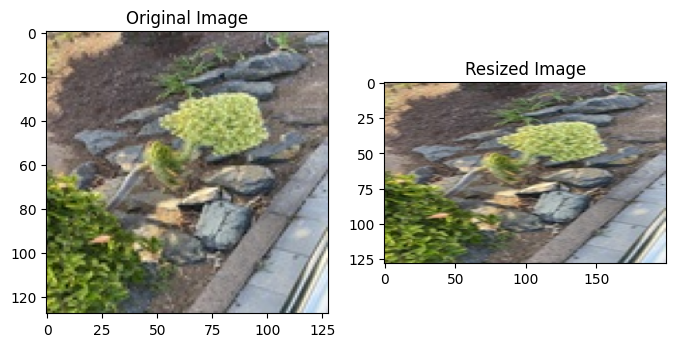

In [94]:
transforms = v2.Compose([
   v2.ToImage(),  # Convert the image to a tensor since our image is in PIL format
   v2.Resize(size=(128, 200), antialias=True), # Resize to 128 x 200
   v2.ToPILImage(),  # Convert it back to PIL to display
])

resize_image = transforms(image)

plot_images(image, resize_image, 'Original Image', 'Resized Image')

#### Horizontal Flip

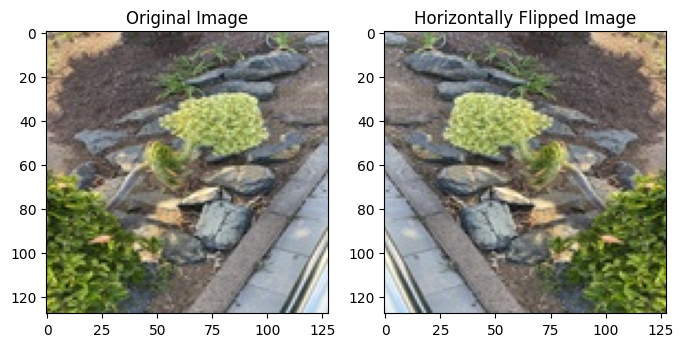

In [95]:
transforms = v2.Compose([
   v2.ToImage(),  # Convert the image to a tensor since our image is in PIL format
   v2.RandomHorizontalFlip(p=1), 
   v2.ToPILImage(), # Convert it back to PIL to display
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Original Image', 'Horizontally Flipped Image')

#### Vertical Flip

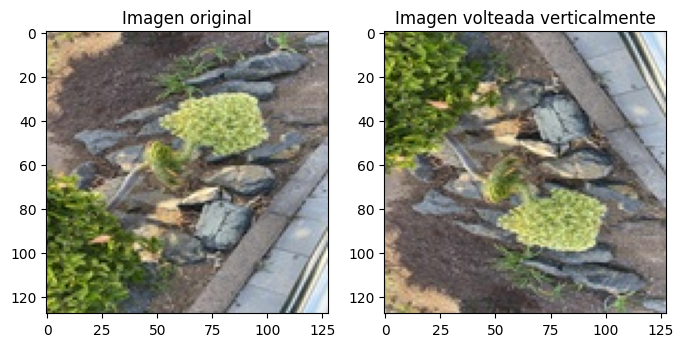

In [96]:
transforms = v2.Compose([
   v2.ToImage(),  # Convert the image to a tensor since our image is in PIL format
   v2.RandomVerticalFlip(p=1), 
   v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen volteada verticalmente')

#### Color Transformation

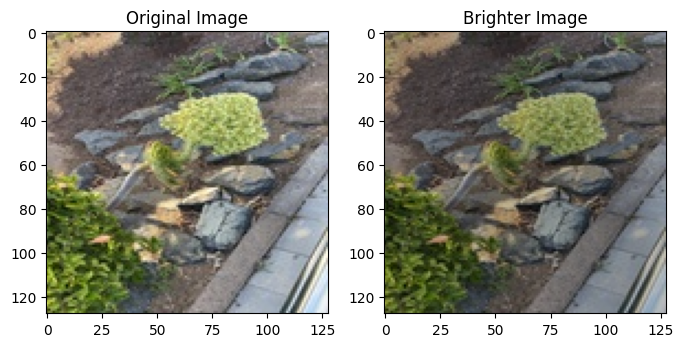

In [97]:
transforms = v2.Compose([
   v2.ToImage(),  # Convert the image to a tensor since our image is in PIL format
   v2.ColorJitter(brightness=1), 
   v2.ToPILImage(), # Convert it back to PIL to display
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Original Image', 'Brighter Image')

#### Delimitar la Imagen

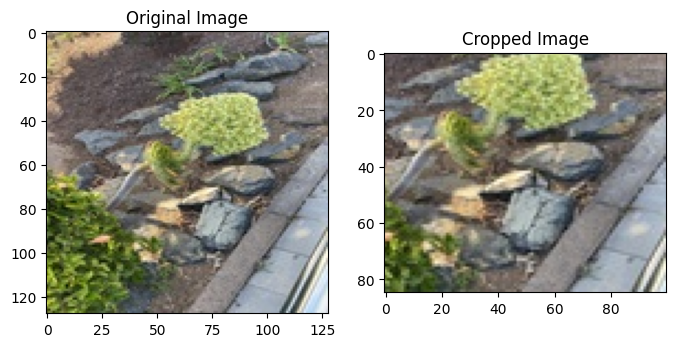

In [98]:
transforms = v2.Compose([
   v2.ToImage(),  # Convert the image to a tensor since our image is in PIL format
   v2.RandomCrop(size=(85,100)), # size specifies the new size of the image
   v2.ToPILImage(), # Convert it back to PIL to display
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Original Image', 'Cropped Image')

#### Rotar la Imagen

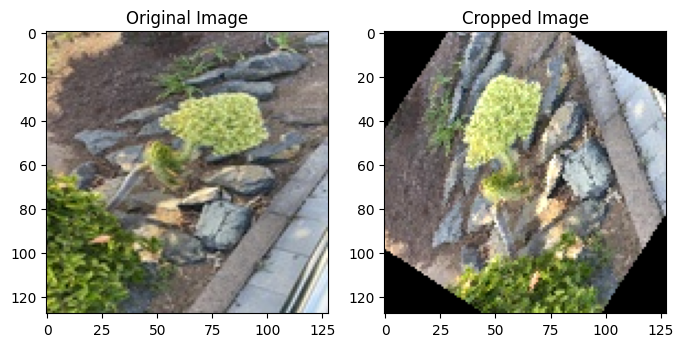

In [99]:
transforms = v2.Compose([
   v2.ToImage(), 
   v2.RandomRotation(degrees=60), # degrees especifica cuánto rotar la imagen
   v2.ColorJitter(brightness=1),  
   v2.ToPILImage(), 
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Original Image', 'Cropped Image')

#### Normalize the Image

Normalize an image with a specific mean and standard deviation.

There are three values for the mean and standard deviation since the image has 3 channels.

**Transformation:** (pixel value - mean value for the channel) / standard deviation for the channel

In [100]:
transforms = v2.Compose([
   v2.ToImage(),
   v2.ToDtype(torch.float32, scale=True),  # Change the number format to float and scale it between 0 and 1
   v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalizar la imagen entre -1 y 1. Algunos modelos quieren: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] 
])

normalize_image = transforms(image)

In [101]:
# Scaled image values 
numpy_image = np.asarray(normalize_image)
print(numpy_image.shape)
print('Maximum pixel value in the image after normalization:: ', numpy_image.max())
print('Minimum pixel value in the image after normalization: ', numpy_image.min())
print('Mean pixel value in the image after normalization: ', numpy_image.mean())

(3, 128, 128)
Maximum pixel value in the image after normalization::  1.0
Minimum pixel value in the image after normalization:  -1.0
Mean pixel value in the image after normalization:  -0.08890607


## Convolutional Network Exploration

### Loading the CIFAR-10 Dataset

#### Dataset

In [102]:
import torchvision.transforms as transforms

# Transformations to convert images into tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize pixel values between -1 and 1
])

# Download the CIFAR-10 dataset and apply transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### DataLoader

In [103]:
# Create DataLoader for the training and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

#### Tests

In [104]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

### CNN Model Variants

#### Base Model

In [105]:
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=0)
    # Añadir mas capas
)
for images, labels in train_loader:
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 30, 30])


In [106]:
cnn_model

Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
)

#### V1: Padding = 1

In [107]:
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
)

for images, labels in train_loader:
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 32, 32])


In [108]:
cnn_model

Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

#### V2: Stride= 2

In [109]:
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=2, padding=0)
)

for images, labels in train_loader:
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 15, 15])


In [110]:
cnn_model

Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2))
)

#### V3: Kernel Size = 5

In [111]:
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=0)
)

for images, labels in train_loader:
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 28, 28])


In [112]:
cnn_model

Sequential(
  (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
)

#### V4: Pooling

In [113]:
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=0),
    nn.MaxPool2d(kernel_size=2, stride=2)
)

for images, labels in train_loader:
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 15, 15])


In [114]:
cnn_model

Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [115]:
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=0),
    nn.MaxPool2d(kernel_size=4, stride=4)
)

for images, labels in train_loader:
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 7, 7])


In [116]:
cnn_model

Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
)

#### V5: Mix

In [117]:
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2)
)

for images, labels in train_loader:
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 16, 7, 7])


In [118]:
cnn_model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

### Testing Variations

In [119]:
# Padding: 0 y 1
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=0),
    nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
)

for images, labels in train_loader:
    print('Padding=1')
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Padding=1
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 24, 30, 30])


In [120]:
# Stride: 1 y 2
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=0),
    nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=2, padding=0)
)
for images, labels in train_loader:
    print('Padding=1')
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Padding=1
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 24, 14, 14])


In [121]:
# Kernel Size: 3 y 5
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=0),
    nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=0)
)
for images, labels in train_loader:
    print('Padding=1')
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Padding=1
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 24, 26, 26])


In [122]:
# Pooling: kernel_size=2, stride=2
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=0),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=0),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
for images, labels in train_loader:
    print('Padding=1')
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Padding=1
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 24, 6, 6])


In [123]:
# Pooling: kernel_size=4, stride=4
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=0),
    nn.MaxPool2d(kernel_size=4, stride=4),
    nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=0),
    nn.MaxPool2d(kernel_size=4, stride=4)
)
for images, labels in train_loader:
    print('Padding=1')
    print('Input shape: ', images.shape)
    out = cnn_model(images)
    print('Output shape: ', out.shape)
    break

Padding=1
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 24, 1, 1])
